TIPS:

- We initialize the bias `b2` to zero, rather than from a normal distribution.
- We initialize the weights `W2` to have smaller variance than `1.0` (to avoid extreme values)

In [54]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 

In [55]:
# Read data
names = open("names.txt", "r").read().splitlines()

# Build vocabulary
characters = sorted(list(set(''.join(names))))
str_to_int = {s:i+1 for i, s in enumerate(characters)}
str_to_int['.'] = 0.0
int_to_str = {i:s for s, i in str_to_int.items()}
vocab_size = len(int_to_str)

In [56]:
block_size = 3  # context size

def build_dataset(names):
    X, Y = [], []
    for name in names:
        context = [0] * block_size
        for character in name + ".":
            ix = str_to_int[character]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y, dtype=torch.long)
    print(X.shape, Y.shape)
    return X, Y

In [57]:
import random 
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [58]:
# MLP
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb),           generator=g)  # embedding
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g) * (5/3) / (n_emb*block_size)**0.5
b1 = torch.randn(n_hidden,                     generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),       generator=g) * 0.01
b2 = torch.randn(vocab_size,                   generator=g) * 0

parameters = [C, W1, b1, W2, b2]  # All parameters of our network
print("Total parameters: ", sum(p.nelement() for p in parameters))

# Allow gradients
for p in parameters:
    p.requires_grad = True

Total parameters:  11897


In [59]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb]   # embedding
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Zero gradients
    for p in parameters:
        p.grad = None

    # Backward pass  
    loss.backward()
    
    # Gradient descent
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track statistics
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


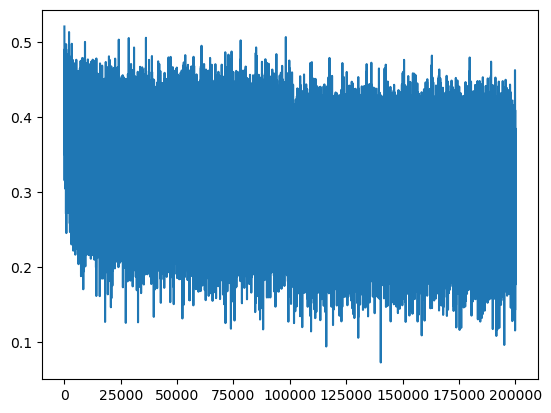

In [51]:
plt.plot(lossi)

In [52]:
@torch.no_grad()  # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.1026785373687744


In [53]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size   # initialize with all dots
    while True:
        emb = C[torch.tensor([context])]  # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(int_to_str[i] for i in out))

carmahzauri.
jai.
kimri.
reh.
casparsha.
jazhith.
deliah.
jareei.
nellara.
chaily.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
waythoniearyn.
kai.
euliyuan.
eddeli.


# Advice
If we check `h` as a histogram after the first iteration, we see that it has most of its values one side or the other (either -1 or 1).

In [41]:
import random 
random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

Xtr, Ytr = build_dataset(names[:n1])
Xdev, Ydev = build_dataset(names[n1:n2])
Xte, Yte = build_dataset(names[n2:])

# MLP
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb),           generator=g)  # embedding
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden,                     generator=g) * 0.01 # not set to zero, to allow some diversity
W2 = torch.randn((n_hidden, vocab_size),       generator=g) * 0.01
b2 = torch.randn(vocab_size,                   generator=g) * 0

parameters = [C, W1, b1, W2, b2]  # All parameters of our network
print("Total parameters: ", sum(p.nelement() for p in parameters))

# Allow gradients
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb]   # embedding
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Zero gradients
    for p in parameters:
        p.grad = None

    # Backward pass  
    loss.backward()
    
    # Gradient descent
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track statistics
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    break

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])
Total parameters:  11897
      0/ 200000: 3.2954


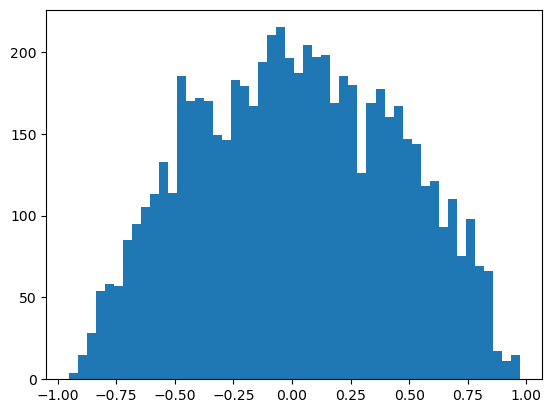

In [42]:
plt.hist(h.view(-1).tolist(), bins=50);

This happens because the pre-activations values are very broad

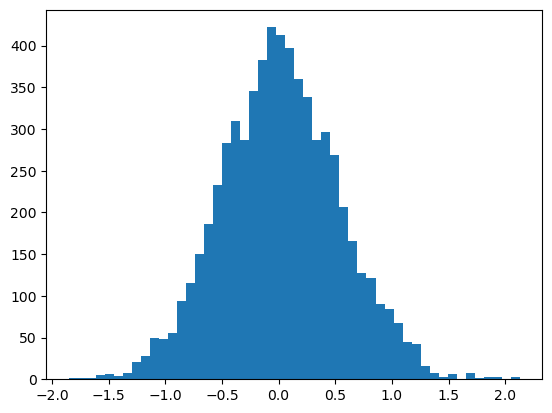

In [43]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

This is because the gradient of `tanh` is `1 - tanh^2` and therefore when `tanh` value is close to `\pm 1` we basically get zero gradient.

Let's see how often is the activation larger than 0.99 in absolute value

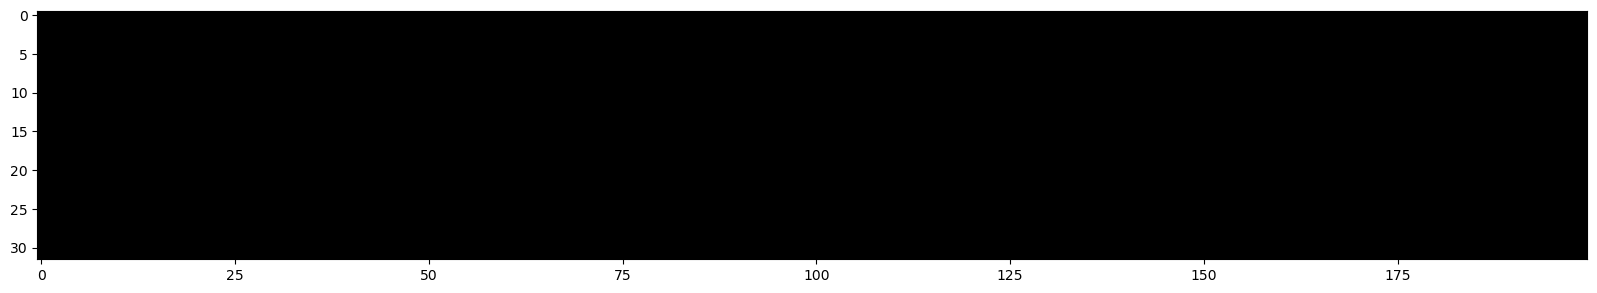

In [44]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# Further Advice

Generally, we want the variance of `x @ w` to be roughly one. Turns out, that one can do that by dividing `x @ w` by the square root of the number of inputs. [This](https://arxiv.org/abs/1502.01852) paper talks about various strategies.

The idea is that RELU throws away about half of the distribution (the negative part) and therefore one should divide by $\sqrt{2 / n_l}$ rather than $\sqrt{n_l}$ to compensate for that. Often one calls $n_l$ the `fan in`.

All of this is implemented in PyTorch and it is called `kaiming_normal` precisely `torch.nn.init.kaiming_normal_()`.]

HOWEVER, nowadays these things matter a bit less thanks to some innovations:

1. Residual connections
2. Normalization layers (Batch, layer, group etc)
3. Better optimizers RMSprop and Adam

In practice, Andrey initializes the weights and normalizes them the by square root of the fan in.

# Batch Normalization
Allows to train deep neural networks more reliably, introduced in [this](https://arxiv.org/abs/1502.03167) paper. This is motivated by the same problems that motivated Kaiming initialization: we would like the input to the activation function to be roughly $\mathcal{N}(0, 1)$. Batch normalization simply normalizes the input to the activation to achieve that, and since it does so in a fully-differentiable manner - it works!

As the name says: we **take the mean along all the elements in the batch**

> We want the pre-activations to be roughly Gaussians **at initialization** but we don't want to these to be forced to be so, all the time. We would like the NN to be able to move it around, make it more or less diffuse, make some `tanh` to be more trigger-happy, or less trigger happy. If our batch is $\mathcal{B} = \{x_1, \ldots, x_m\}$ then we do this:
> 1. Compute the mini-batch mean
$$
\mu_{\mathcal{B}} = \frac{1}{m}\sum_{i=1}^m x_i
$$
> 2. Compute the mini-batch variance
$$
\sigma_{\mathcal{B}}^2 = \frac{1}{m}\sum_{i=1}^m (x_i - \mu_{\mathcal{B}})^2
$$
> 3. Normalize
$$
\hat{x}_i = \frac{x_i - \mu_{\mathcal{B}}}{\sqrt{\sigma_{\mathcal{B}^2 + \epsilon}}}
$$
> 5. Scale and shift
$$
y_i = \gamma \hat{x}_i + \beta = \text{BN}_{\gamma, \beta}(x_i)
$$
Often the "scaling" $\gamma$ is called **gain** and the offset $\beta$ is called **bias**.

IMPORTANCE: If we don't use Batch Normalization, all the training examples in the batch are processed independently. However, once we do use Batch-Normalization, we are coupling these examples in the minibatch mathematically. The side-effect of this is that it acts a a regularizer by adding some jittering, which is good. But the downside is that mathematically, this is much more difficult to analyze.

In [71]:
# MLP
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb),           generator=g)  # embedding
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g) * (5/3) / (n_emb*block_size)**0.5
b1 = torch.randn(n_hidden,                     generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),       generator=g) * 0.01
b2 = torch.randn(vocab_size,                   generator=g) * 0

# Batch normalization
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]  # All parameters of our network
print("Total parameters: ", sum(p.nelement() for p in parameters))

# Allow gradients
for p in parameters:
    p.requires_grad = True

Total parameters:  12297


In [72]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb]   # embedding
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    hpreact = hpreact - hpreact.mean(dim=0, keepdims=True)
    hpreact = hpreact / hpreact.std(dim=0, keepdims=True)
    hpreact = bngain*hpreact + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Zero gradients
    for p in parameters:
        p.grad = None

    # Backward pass  
    loss.backward()
    
    # Gradient descent
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track statistics
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


Imagine that, after training we wish to feed a single datapoint through the network. How can we do that if we have batch normalization? The authors of the paper suggest doing something called **calibrating the batch norm statistics**.

In [73]:
# Calibrate BN at the end of training
with torch.no_grad():
    # Pass the tranining set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # Measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdims=True)
    bnstd = hpreact.std(0, keepdims=True)

Basically we compute $\gamma$ and $\beta$ from feeding the entire training set through the network, and then use this at test/production time.

In [74]:
@torch.no_grad()  # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # bngain, bnbias: learned
    # bnmean, bnstd: computed over training set
    hpreact = bngain * ((hpreact - bnmean) / bnstd) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668270587921143
val 2.1049270629882812


Actually, it turns out one can compute `bnmean` and `bnstd` in a running fashion, during training of the Neural Network.

In [76]:
# MLP
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb),           generator=g)  # embedding
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g) * (5/3) / (n_emb*block_size)**0.5
b1 = torch.randn(n_hidden,                     generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),       generator=g) * 0.01
b2 = torch.randn(vocab_size,                   generator=g) * 0

# Batch normalization
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

#### THESE REQUIRE NO GRADIENT ###############
bnmean_running = torch.zeros((1, n_hidden))  #
bnstd_running = torch.ones((1, n_hidden))    #
##############################################

parameters = [C, W1, b1, W2, b2, bngain, bnbias]  # All parameters of our network
print("Total parameters: ", sum(p.nelement() for p in parameters))

# Allow gradients
for p in parameters:
    p.requires_grad = True


max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb]   # embedding
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 #+ b1, # b1 is useless here since we normalize
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias

    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Zero gradients
    for p in parameters:
        p.grad = None

    # Backward pass  
    loss.backward()
    
    # Gradient descent
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track statistics
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

Total parameters:  12297
      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [78]:
@torch.no_grad()  # disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # bngain, bnbias: learned
    # bnmean, bnstd: computed over training set
    hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.06659197807312
val 2.1050572395324707


Typically one does not just divide by the std of the batch but by $\sqrt{\sigma_{\mathcal{B}}^2 + \epsilon}$ where $\epsilon$ is a small value that prevents division by zero. Also, notice that `b1` is being useless since we are dividing by the mean of the batch. General rule:

> Whenever using BatchNorm layers, if you have any weight layer before, you can remove the bias. The BN bias is going to take its place.